#### Notes:
- Make sure you are switched to GPU
- Code is not cleaned and not reviewed yet


# ***Loading Packages*** 

In [ ]:
!pip install transformers
!pip install tensorflow-text

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
np.set_printoptions(precision=2, linewidth=80)
import torch
from nltk.tokenize.toktok import ToktokTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
english_stopwords = stopwords.words('english')
stemmer = SnowballStemmer('english')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import (BertForSequenceClassification, BertTokenizer, AdamW, BertConfig, get_linear_schedule_with_warmup)
from transformers import AutoTokenizer, AutoModel
from sklearn import preprocessing
from torch.utils.data import TensorDataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import sklearn.metrics as metrics
import operator
import random
import time
import datetime

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
nltk.download('wordnet')
all_stopwords = nlp.Defaults.stop_words

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
tokenizer = ToktokTokenizer()

In [ ]:
if torch.cuda.is_available():        
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('CPU is exist.')

GPU: Tesla K80


In [ ]:
device

device(type='cuda')

In [ ]:
# loading base BERT tokenizer
tokenizerBERT = BertTokenizer.from_pretrained("bert-base-uncased") # 'bert-base-uncased' original

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    # "bert-base-uncased",   original 
    "bert-base-uncased",
    num_labels = 2,                 
    output_attentions = False, 
    output_hidden_states = True,  # originally False
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
optimizer = AdamW(model.parameters(),lr = 2e-5, eps = 1e-8)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


# 1. Loading Dataset

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# ICD_train = pd.read_csv('/gdrive/MyDrive/dataset/DIA_GROUPS_3_DIGITS_adm_train.csv')
# ICD_test = pd.read_csv('/gdrive/MyDrive/dataset/DIA_GROUPS_3_DIGITS_adm_test.csv')
# ICD_val = pd.read_csv('/gdrive/MyDrive/dataset/DIA_GROUPS_3_DIGITS_adm_val.csv')

# # noteevents_df = pd.read_csv("/gdrive/My Drive/dataset/NOTEEVENTS.csv") 
# # icd_df = pd.read_csv("/gdrive/My Drive/dataset/DIAGNOSES_ICD.csv")
# # admin_df = pd.read_csv("/gdrive/My Drive/dataset/ADMISSIONS.csv")

# # df = pd.read_csv("/gdrive/My Drive/dataset/dataset_cleaned.csv")

Mounted at /gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df =  pd.read_csv("/content/drive/MyDrive/AI Projects and Dataset/Health ML/IMDB Dataset.csv")

In [ ]:
df.head()

,text,label
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.drop(columns={"index"}, inplace = True)
df = df.rename(columns = {'review':'text', 'sentiment':'label'})

In [ ]:
df.head()

,text,label
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
from bs4 import BeautifulSoup

In [ ]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
df['text']=df['text'].apply(denoise_text)

In [ ]:
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
df['text']=df['text'].apply(remove_special_characters)

In [ ]:
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
df['text']=df['text'].apply(simple_stemmer)

In [ ]:
stopword_list=nltk.corpus.stopwords.words('english')

In [ ]:
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
df['text']=df['text'].apply(remove_stopwords)

{"she's", "won't", "wouldn't", 'again', 'their', 'been', 'no', "should've", 't', 'when', 'on', 'with', 'to', "shan't", "couldn't", 'there', 'where', 're', 'being', 'such', 'aren', 'him', 'those', 'our', 'd', 'between', 'off', 'both', 'so', 'here', 'herself', 'below', 'it', 'theirs', 'of', 'your', 'won', "hasn't", 'weren', "mustn't", 'didn', 'how', 'which', 'each', 'himself', "hadn't", 'some', 'under', "don't", 'why', 'who', 'whom', 'into', 'very', 'y', 'through', 'don', 'we', 'by', 'yourselves', 'them', 'during', 'after', 'yours', 'doing', 'shan', 'too', 'all', 'mustn', 'should', "needn't", 'a', 'had', 'if', 'before', 'wouldn', 've', 'these', 'while', 'has', 'ours', 'm', 'hadn', "haven't", 'down', 'and', 'me', 'they', 'my', 'just', 'his', "isn't", 'was', 'having', 'same', "you'd", 'will', "didn't", 'any', 'more', 'have', "weren't", 'few', 'be', 'doesn', 'did', 'do', 'is', 'about', "wasn't", 'hasn', 'not', 'at', "you've", 'does', 'now', "you'll", 'were', 'o', 'but', 'ain', 'can', 'yours

In [ ]:
from sklearn import preprocessing

In [ ]:
label_encoder = preprocessing.LabelEncoder()

In [ ]:
df.label = label_encoder.fit_transform(df.label)

In [ ]:
df.head()

,text,label
0,one review ha mention watch 1 Oz episod youll ...,1
1,wonder littl product film techniqu veri unassu...,1
2,thought thi wa wonder way spend time hot summe...,1
3,basic famili littl boy jake think zombi hi clo...,0
4,petter mattei love time money visual stun film...,1


In [ ]:
df.to_csv("IMDB_CLEANED.csv", index = False)

In [ ]:
# !pip install contractions
# import contractions

In [ ]:
# df = pd.concat([ICD_train, ICD_test, ICD_val]) # issue of duplicate indices

In [ ]:
df.shape

(50000, 2)

In [ ]:
df.index.duplicated().sum()

0

In [ ]:
df.reset_index(inplace = True)

In [ ]:
df.index.duplicated().sum()

0

In [ ]:
# def filter_admission_text(notes_df) -> pd.DataFrame:
#     """
#     Filter text information by section and only keep sections that are known on admission time.
#     """
#     admission_sections = {
#         "CHIEF_COMPLAINT": "chief complaint:",
#         "PRESENT_ILLNESS": "present illness:",
#         "MEDICAL_HISTORY": "medical history:",
#         "MEDICATION_ADM": "medications on admission:",
#         "ALLERGIES": "allergies:",
#         "PHYSICAL_EXAM": "physical exam:",
#         "FAMILY_HISTORY": "family history:",
#         "SOCIAL_HISTORY": "social history:"
#     }

#     # replace linebreak indicators
#     notes_df['text'] = notes_df['text'].str.replace(r"\n", r"\\n")

#     # extract each section by regex
#     for key in admission_sections.keys():
#         section = admission_sections[key]
#         notes_df[key] = notes_df.text.str.extract(r'(?i){}(.+?)\\n\\n[^(\\|\d|\.)]+?:'
#                                                   .format(section))

#         notes_df[key] = notes_df[key].str.replace(r'\\n', r' ')
#         notes_df[key] = notes_df[key].str.strip()
#         notes_df[key] = notes_df[key].fillna("")
#         notes_df[notes_df[key].str.startswith("[]")][key] = ""

#     # filter notes with missing main information
# #     notes_df = notes_df[(notes_df.CHIEF_COMPLAINT != "") | (notes_df.PRESENT_ILLNESS != "") |
# #                         (notes_df.MEDICAL_HISTORY != "")]

#     # add section headers and combine into TEXT_ADMISSION
#     notes_df = notes_df.assign(TEXT="CHIEF COMPLAINT: " + notes_df.CHIEF_COMPLAINT.astype(str)
#                                     + '\n\n' +
#                                     "PRESENT ILLNESS: " + notes_df.PRESENT_ILLNESS.astype(str)
#                                     + '\n\n' +
#                                     "MEDICAL HISTORY: " + notes_df.MEDICAL_HISTORY.astype(str)
#                                     + '\n\n' +
#                                     "MEDICATION ON ADMISSION: " + notes_df.MEDICATION_ADM.astype(str)
#                                     + '\n\n' +
#                                     "ALLERGIES: " + notes_df.ALLERGIES.astype(str)
#                                     + '\n\n' +
#                                     "PHYSICAL EXAM: " + notes_df.PHYSICAL_EXAM.astype(str)
#                                     + '\n\n' +
#                                     "FAMILY HISTORY: " + notes_df.FAMILY_HISTORY.astype(str)
#                                     + '\n\n' +
#                                     "SOCIAL HISTORY: " + notes_df.SOCIAL_HISTORY.astype(str))

#     return notes_df

# df_filtered = filter_admission_text(df)

# my_stop_words = ['discharge', 'diagnosis', 'medications', 'medication', 'disposition', 'condition', 'instructions', 
#                  'status', 'secondary', 'changes', 'instruction', 'change', 'home', 'name', 'hospital', 'daily',
#                 'hour', 'follow', 'care', 'time', 'day', 'week', 'with', 'disp', 'discharged', 'admitted', 
#                  'namepattern', 'none', 'chief', 'complaint', 'physical', 'exam', 'present', 'illness', 'family','year', 'history','admission', 'social', 'medical', 'allergies']

# stemmer = WordNetLemmatizer()

# def clean_string(s):
#     # Remove all the special characters
#     s_clean = re.sub(r'\W', ' ', s)
#     s_clean = re.sub('_', ' ', s)
#     # Remove new line characters
#     s_clean = s_clean.replace("\n", ' ')
#     # Punctuation
#     s_clean = re.sub(r'[^\w\s]', ' ', s_clean)
#     # remove all single characters
#     s_clean = re.sub(r'\s+[a-zA-Z]\s+', ' ', s_clean)
#     # Remove single characters from the start
#     s_clean = re.sub(r'\^[a-zA-Z]\s+', ' ', s_clean) 
#     # Substituting multiple spaces with single space
#     s_clean = re.sub(r'\s+', ' ', s_clean, flags=re.I)
#     # Removing prefixed 'b'
#     s_clean = re.sub(r'^b\s+', '', s_clean)
#     #Removing Numbers
#     s_clean = ''.join(i for i in s_clean if not i.isdigit())
#     #Removing Stopwords
#     s_clean = ' '.join([i for i in s_clean.split() if not i in all_stopwords])
#     #Removing certain sized words
#     s_clean = ' '.join([i for i in s_clean.split() if len(i)>3])
#     # Contractions
#     s_clean = contractions.fix(s_clean)
#     # Converting to Lowercase
#     s_clean = s_clean.lower()
#     # Lemmatization
#     s_clean = s_clean.split()
#     s_clean = [stemmer.lemmatize(word) for word in s_clean]
#     s_clean = ' '.join(s_clean)
#     #Removing my_stop_words
#     s_clean = ' '.join([i for i in s_clean.split() if not i in my_stop_words])
#     return s_clean

# df_filtered['TEXT_cleaned'] = [clean_string(s) for s in df_filtered['TEXT']]

In [ ]:
# def get_top_ICD9(s):
#   code = s.split(',')[0]
#   return code

In [ ]:
# df_filtered['top_icd'] = [get_top_ICD9(x) for x in df_filtered['short_codes']]

In [ ]:
# top_classes = df_filtered['top_icd'].value_counts()[0:4].index

In [ ]:
# filter_list = df_filtered['top_icd'].isin(top_classes)
# df_to_predict = df_filtered[filter_list]

In [ ]:
# df_to_predict.head()

In [ ]:
# df.shape, df_to_predict.shape

In [ ]:
# df_to_predict.head()

In [ ]:
# columns_to_drop = [ col for col in df_to_predict.columns if not (col =='TEXT_cleaned' or col == 'top_icd')]

In [ ]:
# df_to_predict.drop(columns=columns_to_drop, axis = 1, inplace=True)

In [ ]:
# df_to_predict.head()

In [ ]:
# df = df_to_predict.copy()

In [ ]:
# df.top_icd.value_counts()

In [ ]:
# def get_data(df:pd.DataFrame):
#   df.top_icd = df.top_icd.map({'414':0, '038': 1, '410':2, '424': 3})
#   df = df.loc[df['top_icd'].isin([0, 1, 2, 3])]
#   df['top_icd'] = df['top_icd'].astype('int64')
#   return df

In [ ]:
# df = get_data(df)
# df = df.iloc[:, 0:]

In [ ]:
# df.top_icd.value_counts()

In [ ]:
# df.index.duplicated().sum()

In [ ]:
# df.rename(columns = {'top_icd':'label', 'TEXT_cleaned':'text'}, inplace = True)

In [ ]:
##do we really neeed anything like this [**Hospital6 8283**] [**9-26**]

In [ ]:
# df.to_csv('dataset_cleaned_sean.csv', index = False)

In [ ]:
df.head()

,index,text,label
0,0,one review ha mention watch 1 Oz episod youll ...,1
1,1,wonder littl product film techniqu veri unassu...,1
2,2,thought thi wa wonder way spend time hot summe...,1
3,3,basic famili littl boy jake think zombi hi clo...,0
4,4,petter mattei love time money visual stun film...,1


Chucking our long clinical texts before apply BERT

## Chunking

In [ ]:
def get_split(text1):
  l_total = []
  l_partial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_partial = text1.split()[:200]
      l_total.append(" ".join(l_partial))
    else:
      l_partial = text1.split()[w*150:w*150 + 200]
      l_total.append(" ".join(l_partial))
  return l_total

In [ ]:
def chunk_text(df:pd.DataFrame, column_name):
  df['text_split'] = df[column_name].apply(get_split)

  train_l = []
  label_l = []
  index_l = []
  
  for idx,row in df.iterrows():
    for l in row['text_split']:
      train_l.append(l)
      label_l.append(row['label'])
      index_l.append(idx)
  df_temp = pd.DataFrame({'TEXT':train_l, 'label':label_l})
  print("Old Shape Before Chunking:", df.shape, "\n", "New Shape After Chunking:", df_temp.shape)
  return df_temp

In [ ]:
# df_temp = pd.read_csv("/content/dataset_cleaned_sean.csv")

In [ ]:
# df_temp.head()

In [ ]:
df_temp = df.copy()

In [ ]:
df_temp['Length'] = df_temp.text.apply(lambda x: len(x.split()))

In [ ]:
df_temp.label[6536]

1

In [ ]:
len(df_temp.text[6536].split())

149

In [ ]:
df_temp.iloc[6536: 6537, :]

,index,text,label,Length
6536,6536,thi show wa exhaust watch onli two number drow...,1,149


In [ ]:
index = df_temp.Length.argmax()
index

31481

In [ ]:
df = chunk_text(df, "text")

Old Shape Before Chunking: (50000, 4) 
 New Shape After Chunking: (54147, 2)


In [ ]:
df.to_csv("IMDB_chunked.csv", index = False)

In [ ]:
df.head()

,TEXT,label
0,one review ha mention watch 1 Oz episod youll ...,1
1,wonder littl product film techniqu veri unassu...,1
2,thought thi wa wonder way spend time hot summe...,1
3,basic famili littl boy jake think zombi hi clo...,0
4,petter mattei love time money visual stun film...,1


In [ ]:
df.shape

(54147, 2)

In [ ]:
df.label.value_counts()

1    27288
0    26859
Name: label, dtype: int64

- 0    3502
- 1    3184
- 2    3175
- 3    1676

#### 2.3 Train Test Split

In [ ]:
df.shape

(54147, 2)

In [ ]:
train, test = train_test_split(df, test_size = 0.3, random_state=42, stratify=df.label.values)

In [ ]:
# train = chunk_text(train, 'TEXT')
# test = chunk_text(test, 'TEXT')

In [ ]:
train.shape

(37902, 2)

In [ ]:
train.head()

,TEXT,label
12775,thi film exactli titl describesan attempt get ...,1
42404,snake train start mexican coupl brujo AJ castr...,0
51615,still favoriteth movi take page alien book del...,1
34850,thi engross woman drama men enjoy plot follow ...,1
32489,tune hi americana drum along mohawk john ford ...,1


In [ ]:
train_texts = train.TEXT
train_labels = train.label
test_texts = test.TEXT
test_labels = test.label

In [ ]:
len(train_texts[10].split())

53

#3. ***Building Model***

## 3.1 Text Preprocessing For BERT

In [ ]:
from transformers import pipeline

[Read Feature Extraction Here](https://huggingface.co/transformers/v3.0.2/main_classes/pipelines.html#:~:text=Feature%20extraction%20pipeline%20using%20Model%20head.%20This%20pipeline%20extracts%20the%20hidden%20states%20from%20the%20base%20transformer%2C%20which%20can%20be%20used%20as%20features%20in%20downstream%20tasks.)

In [ ]:
max_len = 0

for seq in train_texts:
    # Tokenize the text by BERT tokenizer
    input_ids = tokenizerBERT.encode(seq, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

print('Max sequence length:', max_len) 

Max sequence length: 387


In [ ]:
# Tokenize all of the sequences and map the tokens to thier IDs.
input_ids_train = []
attention_masks_train = []

# For every sequences
for seq in train_texts:
    encoded_dict = tokenizerBERT.encode_plus(
                        seq,                             # Sequence to encode
                        add_special_tokens = True,       # Add '[CLS]' and '[SEP]'
                        max_length = 256,                # 128 or 512 ????
                        padding = 'max_length',          # Pad and truncate
                        truncation=True,                 # Truncate the seq
                        return_attention_mask = True,    # Construct attn. masks
                        return_tensors = 'pt',           # Return pytorch tensors
                   )
    
    # Add the encoded sequences to the list    
    input_ids_train.append(encoded_dict['input_ids'])

    '''
    The "Attention Mask" is simply an array of 1s and 0s 
    indicating which tokens are padding and which aren't. 
    This mask tells the "Self-Attention" mechanism in BERT 
    not to incorporate these PAD tokens into its interpretation 
    of the sentence.
    1 indicates a value that should be attended to, while 0 indicates a padded value.
    '''
    attention_masks_train.append(encoded_dict['attention_mask']) 
    
input_ids_train = torch.cat(input_ids_train, dim=0)
attention_masks_train = torch.cat(attention_masks_train, dim=0)
train_label = torch.tensor(train_labels.values)

In [ ]:
# Change to TensorDataset and Split to train and validation sets (80-20)
dataset = TensorDataset(input_ids_train, attention_masks_train, train_label) 
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('Training set size:', format(train_size))
print('Validation set size:', format(val_size))

Training set size: 30321
Validation set size: 7581


## 3.2 Building Dataset and BERT model

In [ ]:
batch_size = 16
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size)
validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size)

In [ ]:
epochs = 2   # recomended 2-4 by BERT model's authors  # on epoch = 2 and chunking is on then we get balanced accuracy of 71% on test
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# 4. ***Model Training***

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Training start
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# use training_status to store loss values, accuracy and elapsed time
training_status = []
total_t0 = time.time()

for epoch_i in range(0, epochs):

    #-------------------Training-----------------------#
    print('Epoch {:} / {:}'.format(epoch_i + 1, epochs))

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):


      if step % 100 == 0 and not step == 0:

        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
      

      model.zero_grad()       
      loss, logits, output_hidden_state_train = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels,
                             return_dict = False)
        
      total_train_loss += loss.item()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      optimizer.step()
      scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)             
    training_time = format_time(time.time() - t0)

    print("\n")
    print(" Average training loss: {0:.2f}".format(avg_train_loss))
    print(" Training epoch took: {:}".format(training_time))
         
    # ------------------Validation--------------------#

    print("\n")
    print("Validation")

    t0 = time.time()
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        
            (loss, logits, output_hidden_state_val) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels,
                                   return_dict = False)

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_status.append(
        {
            'Epochs': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Validation Loss': avg_val_loss,
            'Validation Accuracy.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("\n")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

Epoch 1 / 2
  Batch   100  of  1,896.    Elapsed: 0:02:21.
  Batch   200  of  1,896.    Elapsed: 0:04:40.
  Batch   300  of  1,896.    Elapsed: 0:07:00.
  Batch   400  of  1,896.    Elapsed: 0:09:19.
  Batch   500  of  1,896.    Elapsed: 0:11:38.
  Batch   600  of  1,896.    Elapsed: 0:13:58.
  Batch   700  of  1,896.    Elapsed: 0:16:17.
  Batch   800  of  1,896.    Elapsed: 0:18:37.
  Batch   900  of  1,896.    Elapsed: 0:20:56.
  Batch 1,000  of  1,896.    Elapsed: 0:23:16.
  Batch 1,100  of  1,896.    Elapsed: 0:25:35.
  Batch 1,200  of  1,896.    Elapsed: 0:27:55.
  Batch 1,300  of  1,896.    Elapsed: 0:30:15.
  Batch 1,400  of  1,896.    Elapsed: 0:32:34.
  Batch 1,500  of  1,896.    Elapsed: 0:34:53.
  Batch 1,600  of  1,896.    Elapsed: 0:37:13.
  Batch 1,700  of  1,896.    Elapsed: 0:39:32.
  Batch 1,800  of  1,896.    Elapsed: 0:41:52.


 Average training loss: 0.36
 Training epoch took: 0:44:04


Validation
  Accuracy: 0.88
  Validation Loss: 0.00
  Validation took: 0:03:58


## 4.1 Building Test Dataset

In [ ]:
# Tokenize all of the sequences and map the tokens to thier IDs.
input_ids_test = []
attention_masks_test = []

# For every sequences
for seq in test_texts:
    encoded_dict = tokenizerBERT.encode_plus(
                        seq,                             # Sequence to encode
                        add_special_tokens = True,       # Add '[CLS]' and '[SEP]'
                        max_length = 256,               # 128 or 512 ???
                        padding = 'max_length',          # Pad and truncate
                        truncation=True,                 # Truncate the seq
                        return_attention_mask = True,    # Construct attn. masks
                        return_tensors = 'pt',           # Return pytorch tensors
                   )
    
    # Add the encoded sequences to the list    
    input_ids_test.append(encoded_dict['input_ids'])

    # And its attention mask
    attention_masks_test.append(encoded_dict['attention_mask'])
    
input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)
test_labels = torch.tensor(test_labels.values)

In [ ]:
batch_size = 16
prediction_data = TensorDataset(input_ids_test, attention_masks_test, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
len(prediction_dataloader), len(prediction_data), len(prediction_sampler)

(1016, 16245, 16245)

# 4.2 Evaluating Model

In [ ]:
print('Predicting labels for {:,} test sentences'.format(len(input_ids_test)))

predictions , true_labels = [], []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()    
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

Predicting labels for 16,245 test sentences


In [ ]:
true_labels_array, result_label, result_prob, result_logits = [], [], [], []
for j in range(len(true_labels)):
    for i in range(len(true_labels[j])):
        true_labels_array.append(true_labels[j][i])


for j in range(len(predictions)):
    for i in range(len(predictions[j])):      
        index, value = max(enumerate(predictions[j][i]), key=operator.itemgetter(1))
        result_label.append(index)
        result_prob.append(value)
        result_logits.append(predictions[j][i])

## 4.3 Model Performance: Base BERT

In [ ]:
from sklearn.metrics import balanced_accuracy_score

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def confusion_plot(cm):
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap="Blues"); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix')
    labels = ['Chronic Heart', 'Sepsis','Heart Attack','Endocardium']
    ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)

Accuracy             :  0.8936903662665435
Precision            :  0.8937626894533164
Recall               :  0.8937525903487731
F1                   :  0.8936903082574713
Balanced Accuracy    :  0.8937525903487731


              precision    recall  f1-score   support

           0       0.89      0.90      0.89      8058
           1       0.90      0.89      0.89      8187

    accuracy                           0.89     16245
   macro avg       0.89      0.89      0.89     16245
weighted avg       0.89      0.89      0.89     16245



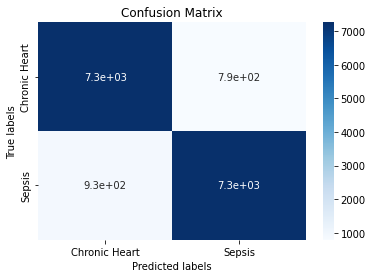

In [ ]:
target_names = ['0','1']

print("Accuracy             : ", accuracy_score(test_labels, result_label))
print("Precision            : ", precision_score(test_labels, result_label, average="macro"))
print("Recall               : ", recall_score(test_labels, result_label, average='macro'))
print("F1                   : ", f1_score(test_labels, result_label, average="macro"))
print('Balanced Accuracy    : ', balanced_accuracy_score(test_labels, result_label))
print("\n")
print(classification_report(true_labels_array, result_label, target_names=target_names))

cmt = metrics.confusion_matrix(test_labels, result_label)
confusion_plot(cmt)

# 5. Save Fine tuned model

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
!pip freeze > requirements.txt 

In [ ]:
output_model = '/content/drive/MyDrive/AI Projects and Dataset/Health ML/bert_fined_tune_chunked_IMDB.pth'

In [ ]:
# save
def save(model, optimizer):
    # save
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, output_model)

save(model, optimizer)


In [ ]:
device

device(type='cuda')

In [ ]:
checkpoint = torch.load(output_model, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/AI Projects and Dataset/Health ML/dataframe_cleaned_chunked.csv")

In [ ]:
train_texts = df.TEXT
train_labels = df.label

In [ ]:
# Tokenize all of the sequences and map the tokens to thier IDs.
input_ids_train = []
attention_masks_train = []

# For every sequences
for seq in train_texts:
    encoded_dict = tokenizerBERT.encode_plus(
                        seq,                             # Sequence to encode
                        add_special_tokens = True,       # Add '[CLS]' and '[SEP]'
                        max_length = 256,                # 128 or 512 ????
                        padding = 'max_length',          # Pad and truncate
                        truncation=True,                 # Truncate the seq
                        return_attention_mask = True,    # Construct attn. masks
                        return_tensors = 'pt',           # Return pytorch tensors
                   )
    
    # Add the encoded sequences to the list    
    input_ids_train.append(encoded_dict['input_ids'])

    '''
    The "Attention Mask" is simply an array of 1s and 0s 
    indicating which tokens are padding and which aren't. 
    This mask tells the "Self-Attention" mechanism in BERT 
    not to incorporate these PAD tokens into its interpretation 
    of the sentence.
    1 indicates a value that should be attended to, while 0 indicates a padded value.
    '''
    attention_masks_train.append(encoded_dict['attention_mask']) 
    
input_ids_train = torch.cat(input_ids_train, dim=0)
attention_masks_train = torch.cat(attention_masks_train, dim=0)
train_label = torch.tensor(train_labels.values)

In [ ]:
# input_ids_full, attention_masks_full, train_label = get_encodings(TEXTS, LABELS)

In [ ]:
batch_size = 16
prediction_data = TensorDataset(input_ids_train, attention_masks_train, train_label)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:


predictions , true_labels = [], []

for batch in prediction_dataloader:
    batch = tuple(t.to('cpu') for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()    
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)